# (A) Dependencies


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import warnings
%matplotlib inline

warnings.filterwarnings('ignore')

# (B) Dataset

### Downloading the dataset via kaggle api
- [Kaggle  Dataset](https://www.kaggle.com/datasets/saurabhshahane/twitter-sentiment-dataset)

In [2]:
# Download kaggle api
!pip install -q kaggle

In [3]:
# Creat the convenient dir for token. (The system will seach this dir)
! mkdir ~/.kaggle

- Upload your kaggle token
- For creating a token
  - Sign in your Kaggle account,
  - Open Account section from  your icon menu
  - Scroll to API section
  -  Click on __Create New API Token__
     - It will download kaggle.json file on your machine. 
  - Upload this kaggle.json file into your working directory on your google colab session.
  - Run floowing codes

In [4]:
# upload your kaggle token to download dataset.
from google.colab import files
files.upload();

Saving kaggle.json to kaggle.json


In [5]:
# Copy the json file into correct path, then remove the firt one it
! cp kaggle.json ~/.kaggle/
! rm -f kaggle.json

In [6]:
# Set the token can't readable for other user if you save it somewhere
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
# Download your data "Competition-name"
#! kaggle competitions download -c 'competition-name'
!kaggle datasets download -d saurabhshahane/twitter-sentiment-dataset

 92% 7.00M/7.60M [00:01<00:00, 8.50MB/s]
100% 7.60M/7.60M [00:01<00:00, 5.59MB/s]


In [8]:
!unzip twitter-sentiment-dataset.zip

Archive:  twitter-sentiment-dataset.zip
  inflating: Twitter_Data.csv        


In [9]:
!ls

sample_data  Twitter_Data.csv  twitter-sentiment-dataset.zip


## Loading the dataset

In [2]:
df = pd.read_csv('Twitter_Data.csv')
df_spare = df.copy()
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [3]:
target_class = "category"

## Dataset Information

The objective of this task is to detect hate speech in tweets. For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it. So, the task is to classify racist or sexist tweets from other tweets.

Formally, given a training sample of tweets and labels, where label '1' denotes the tweet is racist/sexist and label '0' denotes the tweet is not racist/sexist, your objective is to predict the labels on the test dataset.

For training the models, we provide a labelled dataset of 31,962 tweets. The dataset is provided in the form of a csv file with each line storing a tweet id, its label and the tweet.

## Attributes & Stats of the dataset

In [4]:
# datatype info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [5]:
# statistical info
df.describe()

,category
count,162973.000000
mean,0.225436
std,0.781279
min,-1.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


### Implementing Limitatization and Concentration for Sentiment analysis goal.
- Dropping the neutral sentiments to convert the problem binary sentiment classification.

In [6]:
df["category"].unique()

array([-1.,  0.,  1., nan])

In [7]:
# Finding out the neutral sentiments
neutral_sentiments = df[df["category"]==0]

# Removingt the neutral sentiments to improve classification power.
df.drop(neutral_sentiments.index, axis=0, inplace=True)
df["category"].unique()

array([-1.,  1., nan])

# (C) Preprocessing the dataset

## Missing Value Handling

### Finding out the missing values

In [8]:
df.isnull().sum()

clean_text    2
category      7
dtype: int64

In [9]:
df["clean_text"][df["clean_text"].isnull()]

158694    NaN
160560    NaN
Name: clean_text, dtype: object

In [10]:
df["category"][df["category"].isnull()]

130448   NaN
155642   NaN
155698   NaN
155770   NaN
158693   NaN
159442   NaN
160559   NaN
Name: category, dtype: float64

In [11]:
unique_cats = df["category"].unique()
unique_cats , unique_cats[-1]

(array([-1.,  1., nan]), nan)

In [12]:
df["category"][df["category"] == unique_cats[-1]]

Series([], Name: category, dtype: float64)

### Missing value handling

In [13]:
df.isnull().sum()

clean_text    2
category      7
dtype: int64

In [14]:
df.dropna(inplace=True)

In [15]:
df.isnull().sum()

clean_text    0
category      0
dtype: int64

In [16]:
unique_cats = df["category"].unique()
unique_cats

array([-1.,  1.])

In [17]:
df = df.reset_index()

## Text Processing

### (1) Text Cleaning
- Remove twitter spesific characters
- Remove language spesific special characters (punctuations, special chars, numbers)

In [18]:
# removes pattern in the input text
def remove_pattern(input_txt, pattern):

    # Finding all the texts which fits the pattern
    r = re.findall(pattern, input_txt)
    
    # removing this words
    for word in r: input_txt = re.sub(word, "", input_txt)
    
    return input_txt

In [19]:
;# remove twitter handles (@user)
df['clean_text'] = np.vectorize(remove_pattern)(df['clean_text'], "@[\w]*")

In [20]:
# remove special characters, numbers and punctuations
df['clean_text'] = df['clean_text'].str.replace("[^a-zA-Z#]", " ")
df.head()

,index,clean_text,category
0,0,when modi promised minimum government maximum...,-1.0
1,2,what did just say vote for modi welcome bjp t...,1.0
2,3,asking his supporters prefix chowkidar their n...,1.0
3,4,answer who among these the most powerful world...,1.0
4,8,with upcoming election india saga going import...,1.0


### (2) Remove rare words (Outliers)(Generalization)
- Remove rare words to increase generalization of the model

In [21]:
# remove short words
df['clean_text'] = df['clean_text'].apply(lambda x: " ".join([w for w in x.split() if len(w)>3]))
df.head()

,index,clean_text,category
0,0,when modi promised minimum government maximum ...,-1.0
1,2,what just vote modi welcome told rahul main ca...,1.0
2,3,asking supporters prefix chowkidar their names...,1.0
3,4,answer among these most powerful world leader ...,1.0
4,8,with upcoming election india saga going import...,1.0


### (3) Tokenization
- Splitting the text more sensefull structures for learning phrase of the model


In [22]:
# individual words considered as tokens
tokenized_tweet = df['clean_text'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [when, modi, promised, minimum, government, ma...
1    [what, just, vote, modi, welcome, told, rahul,...
2    [asking, supporters, prefix, chowkidar, their,...
3    [answer, among, these, most, powerful, world, ...
4    [with, upcoming, election, india, saga, going,...
Name: clean_text, dtype: object

### (4) Implementing stemmization approach
- Editing the tokenizated words to decrease the variations of the same words. 
- It increase generalization in the SENTIMENT CLASSIFICATION task. Other problems can use diffrent approachs.

In [23]:
# stem the words
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda sentence: [stemmer.stem(word) for word in sentence])
tokenized_tweet.head()

0    [when, modi, promis, minimum, govern, maximum,...
1    [what, just, vote, modi, welcom, told, rahul, ...
2    [ask, support, prefix, chowkidar, their, name,...
3    [answer, among, these, most, power, world, lea...
4    [with, upcom, elect, india, saga, go, import, ...
Name: clean_text, dtype: object

In [24]:
# combine words into single sentence
for i in range(len(tokenized_tweet)): tokenized_tweet[i] = " ".join(tokenized_tweet[i])
    
df['clean_text'] = tokenized_tweet
df.head()

,index,clean_text,category
0,0,when modi promis minimum govern maximum govern...,-1.0
1,2,what just vote modi welcom told rahul main cam...,1.0
2,3,ask support prefix chowkidar their name modi g...,1.0
3,4,answer among these most power world leader tod...,1.0
4,8,with upcom elect india saga go import pair loo...,1.0


In [25]:
df.drop(columns=("index"), inplace=True)
df.head()

,clean_text,category
0,when modi promis minimum govern maximum govern...,-1.0
1,what just vote modi welcom told rahul main cam...,1.0
2,ask support prefix chowkidar their name modi g...,1.0
3,answer among these most power world leader tod...,1.0
4,with upcom elect india saga go import pair loo...,1.0


# (D) Exploratory Data Analysis

## Frequencies via WordCLoud from total text 

In [26]:
import os
if os.system("pip freeze | grep wordcloud==") != 0: os.system("pip install wordcloud")

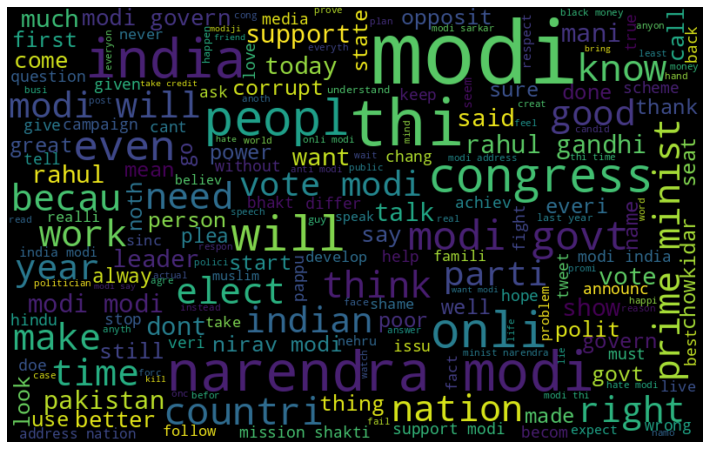

In [27]:
# Getting all the words as text to get worldcloud image.
all_words = " ".join([sentence for sentence in df['clean_text']])

# Generating a wordcloud image of the total words
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100)
all_words_image = wordcloud.generate(all_words)


# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(all_words_image, interpolation='bilinear')
plt.axis('off')
plt.show()

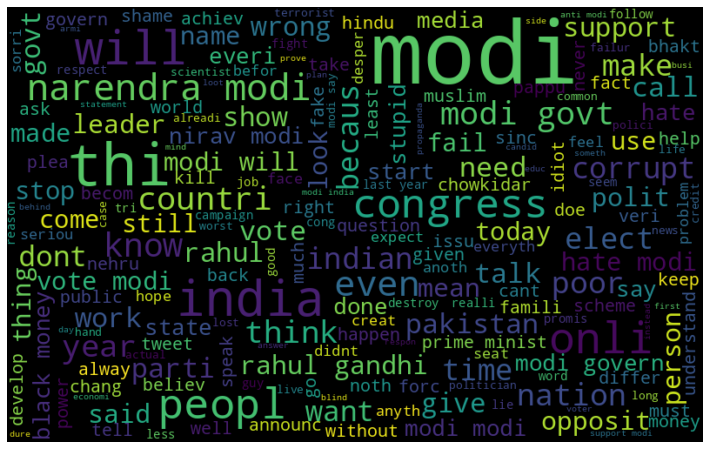

In [28]:
# Getting the text which includes all the negative words 
negative_words = " ".join([sentence for sentence in df['clean_text'][df['category']==-1]])

# Generating a wordcloud image from total of negative words text
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100)
negative_words_image = wordcloud.generate(negative_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

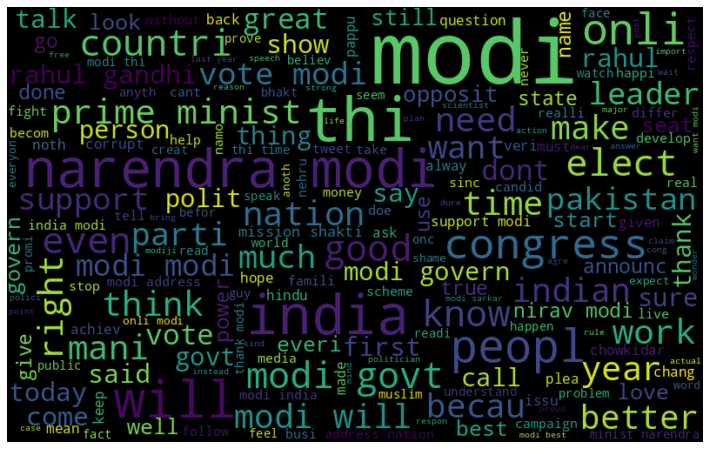

In [29]:
# Getting the text wtich includes all the positive words
positive_words = " ".join([sentence for sentence in df['clean_text'][df['category']==1]])

# Creating a wordcloud image from positive words text
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100)
positive_words_image = wordcloud.generate(positive_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# (E) Model Selection (Classic ML models)

## Prepare The Data To Training

## Input Split

### Encoding the text data via BOW approach
- feature extraction from text as numerically

In [143]:

from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(df['clean_text'])

pickle.dump(bow_vectorizer, open("bow_vectorizer.sav", 'wb'))

### Test-Train split

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(bow, df['category'], random_state=42, test_size=0.25)

## Util Functions
- Utils functions for model tuning

### Greedy Step tune

In [32]:
from sklearn.model_selection import GridSearchCV
from pprint import pprint

def greedy_search(model, params:dict, X_train, y_train, cv=10, n_jobs=-1, verbose=2, is_print=False):
  """It tunes params individually step by step . select best value on current step.
  It assumes the params sorted by importance on the model as descending. 
  The important param, second important param, etc.... 
  """
  
  best_params = {}
  for name, values in params.items():
    # Initial params
    best_params[name] = values

    if is_print: print("before:");pprint(best_params);
    
    # create GridSearch&Train 
    cv_model = GridSearchCV(model, best_params, cv=cv, n_jobs=n_jobs, verbose=verbose)
    cv_model.fit(X_train, y_train)

    # Update the param
    best_params[name] = [cv_model.best_params_[name]]
    
    if is_print: print("after:");pprint(best_params);print("-"*25, end="\n\n");

  return cv_model, cv_model.best_estimator_, best_params

### Model Tuner

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report


def gen_clf_metrics(y_test, y_pred, is_round, return_y_data=False):
  """
  Calculate and return a dictionary of common classification metrics.
  """

  if is_round: y_pred = np.round(y_pred).astype(np.int64)

  clf_metrics = {
            "accuracy":accuracy_score(y_test, y_pred),
            "precision" : precision_score(y_test, y_pred, average="micro"),
            "recall": recall_score(y_test, y_pred, average="micro"),
            "f1_score": f1_score(y_test, y_pred, average="micro"),
            "clf_report":classification_report(y_test, y_pred, output_dict=True)
  }

  if return_y_data:
    clf_metrics["y_pred"] = y_pred
    clf_metrics["y_test"] = y_test
            
  
  return clf_metrics

In [34]:
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error, median_absolute_error

def gen_reg_metrics(y_test, y_pred, is_round, return_y_data=False):
  """
  Calculate and return a dictionary of common regression metrics.
  """

  if is_round: y_pred = np.round(y_pred).astype(np.int64)


  reg_metrics = {
      "MaxError": np.max(y_test - y_pred),
      "MeanAbsoluteError": median_absolute_error(y_test, y_pred),
      "MeanAbsolutePercentageError": np.mean(np.abs((y_test - y_pred) / y_test)) * 100,
      "MSE": mean_squared_error(y_test, y_pred),
      "RMSE": mean_squared_error(y_test, y_pred, squared=False),
      "MAE": mean_absolute_error(y_test, y_pred),
      "R2":r2_score(y_test, y_pred),
      "ExplainedVariance":explained_variance_score(y_test, y_pred)
  }

  if return_y_data:
    reg_metrics["y_pred"] = y_pred
    reg_metrics["y_test"] = y_test


  return reg_metrics

In [35]:
import pandas as pd
def tune_models(tuners, X_train, y_train, X_test, y_test, is_clf, cv=10, is_round=False, return_y_data=False):
  
  results, metric_summary = dict(), dict()
  for name, [model, params] in tuners.items():
    # Tuning
    cv_model, tuned_model, best_params = greedy_search(model, params, X_train, y_train, cv=cv)
    
    # predicting
    y_pred = tuned_model.predict(X_test)
    metric_kwargs = {"y_test":y_test, "y_pred":y_pred, "is_round":is_round, "return_y_data":return_y_data} 
    metric_results = gen_clf_metrics(**metric_kwargs) if is_clf else gen_reg_metrics(**metric_kwargs)

    # Generating results
    cur_results = {
        "tune_results": {
            "cv_model":cv_model,
            "tuned_model":tuned_model,
            "best_params":best_params,
        },
        "metric_results": metric_results
    }
    
    results[name] = cur_results
    metric_summary[name] = metric_results

  return results, pd.DataFrame(metric_summary).T


In [36]:
import pandas as pd
def tune_linear_cv_models(tuners, X_train, y_train, X_test, y_test, is_clf, is_round=False, return_y_data=False):
  
  results, metric_summary = dict(), dict()
  for name, [model, params] in tuners.items():
      # Tuning
      tuned_model = model(**params)
      tuned_model.fit(X_train, y_train)
      
      # predicting
      y_pred = tuned_model.predict(X_test)
      metric_kwargs = {"y_test":y_test, "y_pred":y_pred, "is_round":is_round, "return_y_data":return_y_data} 
      metric_results = gen_clf_metrics(**metric_kwargs) if is_clf else gen_reg_metrics(**metric_kwargs)

      # Generating results
      cur_results = {
          "tune_results": {
              "tuned_model":tuned_model,
              "best_params":tuned_model.get_params(True) ,#best_params_,
          },
          "metric_results": metric_results
      }
      
      results[name] = cur_results
      metric_summary[name] = metric_results

  return results, pd.DataFrame(metric_summary).T

### Learning Curve

In [37]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, name, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), figsize=(20,20)):

    # checking the params
    if ylim is not None: plt.ylim(*ylim)
    
    # pre-declerations
    orange, blue = "#ff9124", "#2492ff"

    # Extracting the learning curve
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    # Extracting the scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # calculating params    
    tra_left_edge = train_scores_mean - train_scores_std
    tra_right_edge = train_scores_mean + train_scores_std

    test_left_edge = test_scores_mean - test_scores_std
    test_right_edge = test_scores_mean + test_scores_std

    # transparent plot for confidence value range
    plt.fill_between(train_sizes, tra_left_edge, tra_right_edge, alpha=0.1, color=orange)
    plt.fill_between(train_sizes, test_left_edge, test_right_edge, alpha=0.1, color=blue)
    
    # Plotting as point
    plt.plot(train_sizes, train_scores_mean, 'o-', color=orange, label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color=blue, label="Cross-validation score")
    
    # Configurating the plottings
    plt.title(f"{name} Learning Curve", fontsize=14)
    plt.xlabel('Training size (m)')
    plt.ylabel('Score')
    plt.grid(True)
    plt.legend(loc="best")

In [38]:
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

def get_learning_curve_stats(clfs, X_train, y_train, cv, model_size, rs, cs, figsize, ylim):

  plt.figure(figsize=figsize)
  # EXtracting the learning curve and validation metrics
  best_models_cross_val_preds, roc_auc_scores = {}, {}
  for i, (name, model) in enumerate(clfs.items()):

    # Training with best models again (the best params already saved inside) for visualizate the duration.
    plt.subplot(rs, cs, i+1)
    print(f"{i}.turn [{name}], plotting learning curve")
    plot_learning_curve(model, name, X_train, y_train, ylim, cv=cv, n_jobs=-1, figsize=figsize) 

    # validating the trained models
    #print(f"{i}.turn, cross_validation")
    #method = "decision_function" if name in ["loj_reg", "svc"] else "predict"
    #best_models_cross_val_preds[name]  = cross_val_predict(model, X_train, y_train, cv=5, method=method)

    # Displating the roc scores
    #print(f"{i}.turn, roc_auc_scores")
    #roc_auc_scores[name] = roc_auc_score(y_train, best_models_cross_val_preds[name])
    #print(f'{name:<20}: ',roc_auc_scores[name])

  return plt.gcf()#, best_models_cross_val_preds#, roc_auc_scores

```python
# Example Usage
model_size = len(us_models)
rs, cs = (model_size//2+1, 4 ) if model_size >= 4 else (model_size//2+1, 2)
lcs_params = {
    "cv" : ShuffleSplit(n_splits=100, test_size=0.2, random_state=42),
    "model_size": model_size,
    "rs":rs,
    "cs":cs,
    "figsize" : (40,20),
    "ylim" : (0.87, 1.01)
}

lc_plot, best_models_cross_val_preds, roc_auc_scores  = get_learning_curve_stats(us_models, figsize=(40,10), **lcs_params)
```

## Model Tuning [Classic ML Models]

### (1) Linear Models

#### Hyperparams

In [51]:
lin_params = {
    'fit_intercept': [True, False],
    #'normalize': [True, False],
    #'copy_X': [True, False],
}
from sklearn.linear_model import LinearRegression
linear_reg = [LinearRegression(), lin_params]

In [52]:
lasso_params = {
    "alphas": np.logspace(-4, 0, 100),
    #"cv": [3, 5, 10],
    #"tol": [1e-4, 1e-3, 1e-2]
}
from sklearn.linear_model import LassoCV
l1_reg = [LassoCV, lasso_params] 

In [53]:
ridge_params = {
    "alphas": (10**np.linspace(10,-2,100))*0.5,
    "scoring":"neg_mean_squared_error",
}

from sklearn.linear_model import RidgeClassifierCV 
l2_reg = [RidgeClassifierCV, ridge_params]

In [54]:
ElasticNet_params = {
    "alphas": np.logspace(-4, 0, 100),
    #"cv": 10, #[3, 5, 10],
    #"normalize": True#[True, False],
    #"tol": [1e-4, 1e-3, 1e-2]
}

from sklearn.linear_model import ElasticNetCV 
enet_reg = [ElasticNetCV, ElasticNet_params]

In [55]:
linear_cv_tuners = {
    "l1_reg":l1_reg,
    "l2_reg":l2_reg,
    "enet_reg":enet_reg
}
linear_tuners = {
    "lin_reg":linear_reg,
    #**linear_cv_tuners
}

#### Tuning Demostration (Undersampled data)
- X_train_us, y_train_us

In [56]:
lin_results, lin_metric_summary = tune_linear_cv_models(linear_cv_tuners, X_train, y_train, X_test, y_test, is_clf=False, is_round=True)

KeyboardInterrupt: ignored

In [ ]:
list(lin_results.keys())

In [ ]:
lin_metric_summary

In [ ]:
from pprint import pprint
pprint(lin_results)

In [ ]:
#tuned_model
lin_results.keys()

In [ ]:
lin_results["l1_reg"].keys()

In [ ]:
lin_results["l1_reg"]["tune_results"].keys()

In [ ]:
size = len(lin_results.keys())
rs, cs = (size//5+1, 5) if size>=5 else (size//3+1, 3)

plt.figure(figsize=(cs*20, rs*20))
lin_models = {}
for i, model_name in enumerate(lin_results.keys()):

  cur_model = lin_results[model_name]["tune_results"]["tuned_model"]
  lin_models[model_name] = cur_model
  
  plt.subplot(rs,cs,i+1)
  pd.Series(cur_model.coef_, X_train.columns).sort_values().plot(kind="barh")
  plt.title(f"{model_name} feature wieghts")

In [ ]:
# Example Usage
model_size = len(lin_models)
rs, cs = (model_size//3+1, 3 ) if model_size >= 3 else (model_size//2+1, 2)
lcs_params = {
    "cv" : ShuffleSplit(n_splits=10, test_size=0.2, random_state=42),
    "model_size": model_size,
    "rs":rs,
    "cs":cs,
    "figsize" : (cs*10,rs*10),
    "ylim" : (0.0, 1.01)
}

lc_plot  = get_learning_curve_stats(lin_models, X_train, y_train,  **lcs_params)

In [ ]:
lin_reg_results, lin_reg_metric_summary = tune_models(linear_tuners, X_train, y_train, X_test, y_test, is_clf=False, is_round=True)

In [ ]:
list(lin_reg_results.keys())

In [ ]:
lin_reg_metric_summary

In [ ]:
from pprint import pprint
pprint(lin_reg_results)

In [ ]:
size = len(lin_reg_results.keys())
rs, cs = (size//5+1, 5) if size>=5 else (size//3+1, 3)

plt.figure(figsize=(cs*20, rs*10))
lin_reg_models = dict()
for i, model_name in enumerate(lin_reg_results.keys()):

  cur_model = lin_reg_results[model_name]["tune_results"]["tuned_model"]
  lin_reg_models[model_name] = cur_model

  plt.subplot(rs,cs,i+1)
  pd.Series(cur_model.coef_, X_train.columns).sort_values().plot(kind="barh")
  plt.title(f"{model_name} feature wieghts")

In [ ]:
# Example Usage
model_size = len(lin_reg_models)
rs, cs = (model_size//2+1, 4 ) if model_size >= 4 else (model_size//2+1, 2)
lcs_params = {
    "cv" : ShuffleSplit(n_splits=10, test_size=0.2, random_state=42),
    "model_size": model_size,
    "rs":rs,
    "cs":cs,
    "figsize" : (cs*10,rs*10),
    "ylim" : (0.0, 1.01)
}

lc_plot  = get_learning_curve_stats(lin_reg_models, X_train, y_train,  **lcs_params)

### (2) Non-Linear Models 

#### Hyperparams

In [58]:
loj_params = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': np.logspace(-3, 3, 7),
    #'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    #'max_iter': [100, 200, 300, 400, 500],
    #'fit_intercept': [True, False],
    #'intercept_scaling': [0.5, 1, 2]
}
from sklearn.linear_model import LogisticRegression
loj_reg = [LogisticRegression(), loj_params]

In [70]:
nb_params = {
    #"priors": [None, [0.1, 0.9], [0.2, 0.8], [0.3, 0.7], [0.4, 0.6], [0.5, 0.5]],
    "var_smoothing":  np.linspace(1e-6, 1e-12, 10)
}
from sklearn.naive_bayes import GaussianNB
nb = [GaussianNB(), nb_params]

In [60]:
knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19],
    #'weights': ['uniform', 'distance'],
    #'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40, 50],
    #'p': [1, 2, 3, 4, 5],
}
from sklearn.neighbors import KNeighborsClassifier
knn = [KNeighborsClassifier() , knn_params]

In [61]:
svc_params = {
    'C': np.logspace(-3, 3, 7),
    #'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    #'degree': [2, 3, 4, 5],
    #'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7)),
    #'coef0': [-1, 0, 1],
    #'shrinking': [True, False],
    #'probability': [True, False],
    #'tol': [1e-3, 1e-4, 1e-5],
    #'max_iter': [-1, 1000, 10000, 100000],
    #"class_weight": [None, "balanced"]
}
from sklearn.svm import SVC
svc = [SVC() , svc_params]

In [62]:
dt_params = {
    #"max_depth": [3, 5, 7, None],
    "min_samples_split": [2, 3, 4, 5],
    "min_samples_leaf": [1, 2, 3, 4],
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    #"max_features": [None, "auto", "log2"],
    #"class_weight": [None, "balanced"]
}
from sklearn.tree import DecisionTreeClassifier
dt = [DecisionTreeClassifier() , dt_params]

In [73]:
non_linear_tuners = {
    "loj_reg":loj_reg,
    #"nb_params":nb,
    "knn":knn,
    #"svc":svc,
    "dt":dt
}

#### Tuning Demostration (Undersampled Data)
- X_train_us, y_train_us



In [74]:
non_lin_results, non_lin_metric_summary = tune_models(non_linear_tuners, X_train, y_train, X_test, y_test, is_clf=True)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 7 candidates, totalling 70 fits
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Fitting 10 folds for each of 2 candidates, totalling 20 fits


In [75]:
list(non_lin_results.keys())

['loj_reg', 'knn', 'dt']

In [76]:
non_lin_metric_summary

,accuracy,precision,recall,f1_score,clf_report
loj_reg,0.830846,0.830846,0.830846,0.830846,"{'-1.0': {'precision': 0.7967988865692415, 're..."
knn,0.729584,0.729584,0.729584,0.729584,"{'-1.0': {'precision': 0.6771145425213183, 're..."
dt,0.785226,0.785226,0.785226,0.785226,"{'-1.0': {'precision': 0.6692307692307692, 're..."


In [77]:
from pprint import pprint
pprint(non_lin_results)

{'dt': {'metric_results': {'accuracy': 0.7852264291017075,
                           'clf_report': {'-1.0': {'f1-score': 0.6747976618705035,
                                                   'precision': 0.6692307692307692,
                                                   'recall': 0.6804579460439809,
                                                   'support': 8822},
                                          '1.0': {'f1-score': 0.8396696962979384,
                                                  'precision': 0.8431274346132442,
                                                  'recall': 0.8362402031129264,
                                                  'support': 18118},
                                          'accuracy': 0.7852264291017075,
                                          'macro avg': {'f1-score': 0.7572336790842209,
                                                        'precision': 0.7561791019220068,
                                                        're

In [83]:
non_lin_reg_models = {model_name:results["tune_results"]["tuned_model"] for model_name, results in non_lin_results.items() if model_name not in ["knn"]}

In [84]:
non_lin_reg_models

{'loj_reg': LogisticRegression(C=0.001, penalty='none'),
 'dt': DecisionTreeClassifier(criterion='entropy', min_samples_leaf=4,
                        min_samples_split=5)}

0.turn [loj_reg], plotting learning curve
1.turn [dt], plotting learning curve


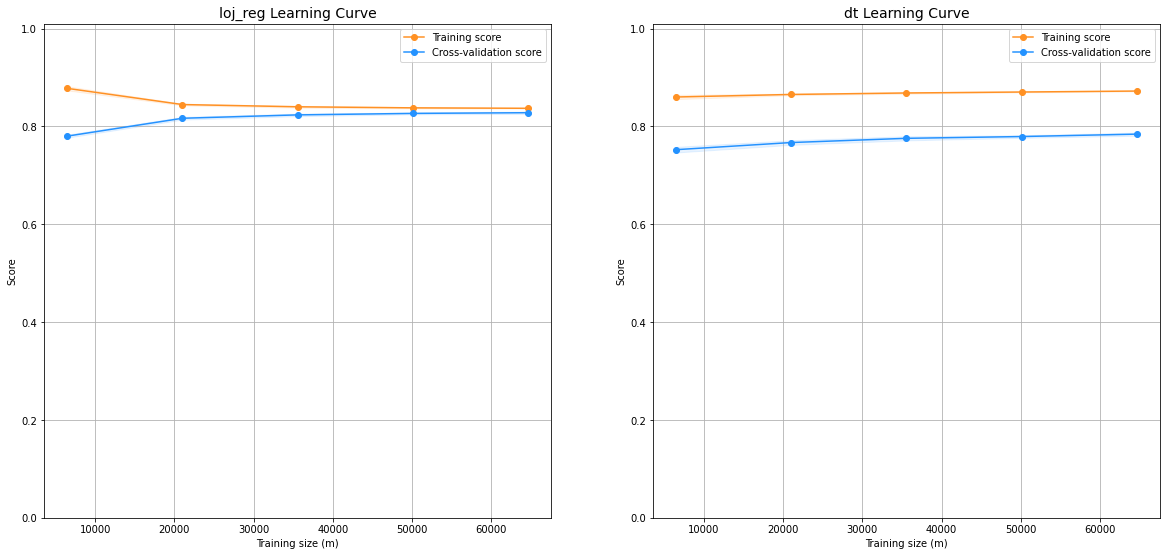

In [85]:
# Example Usage
model_size = len(non_lin_reg_models)
rs, cs = (model_size//4+1, 4 ) if model_size >= 4 else (model_size//2+1, 2)
lcs_params = {
    "cv" : ShuffleSplit(n_splits=10, test_size=0.2, random_state=42),
    "model_size": model_size,
    "rs":rs,
    "cs":cs,
    "figsize" : (cs*10,rs*10),
    "ylim" : (0.0, 1.01)
}

lc_plot  = get_learning_curve_stats(non_lin_reg_models, X_train, y_train,  **lcs_params)

### (3) Ensemble Models

#### Hyperparams

In [115]:
# Defining parameters
rf_params = {
    #"n_estimators": [10, 50, 100, 200],
    "criterion": ["gini", "entropy"],
    #"max_depth": [3, 5, 7, None],
    #"min_samples_split": [2, 4],
    #"min_samples_leaf": [2, 4],
    #"max_features": [None, "auto", "log2"],
    #"class_weight": [None, "balanced"],
    #"bootstrap": [True, False],
    #"oob_score": [True, False],
    #"n_jobs": [None, -1, 1]
}
from sklearn.ensemble import RandomForestClassifier
rf = [RandomForestClassifier(), rf_params] 

In [116]:
# Defining parameters
gbc_params = {
    'learning_rate': [0.1, 0.05, 0.01],
    #'n_estimators': [100, 200, 300],
    #'max_depth': [3, 5, 7],
    #'min_samples_split': [2, 4, 6],
    #'min_samples_leaf': [1, 2, 4],
    #'max_features': ['auto', 'sqrt', 'log2'],
    #'subsample': [0.7, 0.8, 0.9]
}
from sklearn.ensemble import GradientBoostingClassifier
gbc = [GradientBoostingClassifier(), gbc_params] 

In [117]:
# Defining parameters
xgbc_params = {
    #'learning_rate': [0.1, 0.05, 0.01],
    #'n_estimators': [100, 200, 300],
    #'max_depth': [3, 5, 7],
    #'min_child_weight': [1, 2, 4],
    #'gamma': [0, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    #'colsample_bytree': [0.7, 0.8, 0.9],
    #'reg_alpha': [0, 1e-1, 1],
    #'reg_lambda': [0, 1e-1, 1]
}
from xgboost import XGBClassifier
xgbc = [XGBClassifier(), xgbc_params] 

In [122]:
# Defining parameters
lgbm_params = {
    'learning_rate': [0.1, 0.05, 0.01],
    #'n_estimators': [100, 200, 300],
    #'num_leaves': [31, 63, 127],
    #'max_depth': [3, 5, 7],
    #'min_child_samples': [10, 20, 30],
    #'min_child_weight': [1e-3, 1e-2, 1e-1],
    #'subsample': [0.7, 0.8, 0.9],
    #'colsample_bytree': [0.7, 0.8, 0.9],
    #'reg_alpha': [0, 1e-1, 1],
    #'reg_lambda': [0, 1e-1, 1]
}
from lightgbm import LGBMClassifier
lgbm = [LGBMClassifier(), lgbm_params] 

In [123]:
!pip install catboost
import os
if os.system("pip freeze | grep catboost==") != 0: os.system("pip install catboost")

cb_params = {
    'learning_rate': [0.1, 0.05, 0.01],
    #'n_estimators': [100, 200, 300],
    #'depth': [3, 5, 7],
    #'l2_leaf_reg': [1, 2, 4],
    #'boosting_type': ['Ordered', 'Plain', 'Pointwise'],
    #'colsample_bylevel': [0.7, 0.8, 0.9],
    #'reg_lambda': [0, 1e-1, 1] # or # 'l2_leaf_reg': [1, 2, 4]
}
from catboost import CatBoostClassifier
cb = [CatBoostClassifier(), cb_params] 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
ensemble_tuners = {
    "rf":rf,
    #"gbc":gbc,
    #"xgbc":xgbc,
    #"lgbm":lgbm,
    #"cb":cb
}

#### Tuning Demostration (Undersampled Data)
- X_train_us, y_train_us

In [ ]:
ensemble_results, ensemble_metric_summary = tune_models(ensemble_tuners, X_train, y_train, X_test, y_test, is_clf=True)

In [ ]:
list(ensemble_results)

In [ ]:
ensemble_metric_summary

In [ ]:
from pprint import pprint
pprint(ensemble_results)

In [ ]:
non_lin_reg_models = {model_name:results["tune_results"]["tuned_model"] for model_name, results in non_lin_results.items() }

In [ ]:
# Example Usage
model_size = len(non_lin_reg_models)
rs, cs = (model_size//4+1, 4 ) if model_size >= 4 else (model_size//2+1, 2)
lcs_params = {
    "cv" : ShuffleSplit(n_splits=10, test_size=0.2, random_state=42),
    "model_size": model_size,
    "rs":rs,
    "cs":cs,
    "figsize" : (cs*10,rs*10),
    "ylim" : (0.0, 1.01)
}

lc_plot  = get_learning_curve_stats(non_lin_reg_models, X_train, y_train,  **lcs_params)

In [ ]:
es_model_names = [col for col in ensemble_results.keys() if col not in ["bag_reg"]]
size = len(es_model_names)
rs, cs = (size//5+1, 5) if size>=5 else (size//3+1, 3)

plt.figure(figsize=(cs*20, rs*10))
ensemble_reg_models = dict()
for i, model_name in enumerate(es_model_names):
  if model_name in ["bag_reg"]: continue

  cur_model = ensemble_results[model_name]["tune_results"]["tuned_model"]
  ensemble_reg_models[model_name] = cur_model

  plt.subplot(rs,cs,i+1)
  pd.Series(cur_model.feature_importances_, X_train.columns).sort_values().plot(kind="barh")
  plt.title(f"{model_name} feature wieghts")

In [ ]:
# Example Usage
model_size = len(ensemble_reg_models)
rs, cs = (model_size//2+1, 4 ) if model_size >= 4 else (model_size//2+1, 2)
lcs_params = {
    "cv" : ShuffleSplit(n_splits=10, test_size=0.2, random_state=42),
    "model_size": model_size,
    "rs":rs,
    "cs":cs,
    "figsize" : (cs*10,rs*10),
    "ylim" : (0.0, 1.01)
}

lc_plot  = get_learning_curve_stats(ensemble_reg_models, X_train, y_train,  **lcs_params)

### Collectinng the results

In [ ]:
# lin_results, lin_metric_summary
# lin_reg_results, lin_reg_metric_summary
# non_lin_results, non_lin_metric_summary
# ensemble_results, ensemble_metric_summary

#### Collecting the models

In [ ]:
all_results = [lin_results, lin_reg_results, non_lin_results, ensemble_results]

#### Collecting scores

In [ ]:
lin_model_scores = pd.concat([lin_metric_summary, lin_reg_metric_summary])
lin_model_scores = lin_model_scores.sort_values(by=['MSE'], ascending=True)
lin_model_scores

In [ ]:
non_linear_model_scores = pd.concat([non_lin_metric_summary, ensemble_metric_summary])
non_linear_model_scores = non_linear_model_scores.sort_values(by=['accuracy','f1_score'],  ascending=False)
non_linear_model_scores

In [ ]:
non_linear_model_scores.index

## Final Model

### Greedy Selection

In [ ]:
best_model_name = non_linear_model_scores.iloc[0].name, 
best_model_name

In [ ]:
tuned_model, best_params = None, None
for results in all_results:
  if best_model_name in results:
      tuned_model = results[best_model_name]["tune_results"]["tuned_model"]
      best_params = results[best_model_name]["tune_results"]["best_params"]

# (F) Saving & Downloading the model

### Saving the model

In [ ]:
import pickle
model_save_path = 'finalized_model.sav'
pickle.dump(tuned_model, open(model_save_path, 'wb'))

### Loading the model

In [ ]:
loaded_model = pickle.load(open(model_save_path, 'rb'))

In [ ]:
loaded_model.score(X_test, y_test)

### Zipping the model
```python
import os 
zip_dst, src = f"{model_save_path}.zip", model_save_path
os.system(f"zip -r {zip_dst} {src}" )
```

### Downloading the model

In [ ]:
from google.colab import files
files.download(model_save_path)

# (G) Deployment as App

## APP (loading from file)

### Declerations & Util Funcs

In [1]:
!pip install gradio
import gradio as gr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 KB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.9/140.9 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 KB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 KB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 KB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 KB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 4

In [6]:
import pickle
import json 
import numpy as np
import pandas as pd
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
import re

# File Paths
model_path = 'loj_reg_twitter_sentiment.sav'
bow_vectorizer_path = "bow_vectorizer.sav"

# Loading the files
model = pickle.load(open(model_path, 'rb'))
bow_vectorizer = pickle.load(open(bow_vectorizer_path, 'rb'))
stemmer = PorterStemmer()

labels = ["negative", "positive"]#classes[target].values()

In [7]:
def text_preprocessing(input_txt, pattern:str="@[\w]*"):
  # Finding all the texts which fits the pattern
  r = re.findall(pattern, input_txt)
  
  # removing this words
  for word in r: input_txt = re.sub(word, "", input_txt)

  #  removing special characters
  input_txt = input_txt.replace("[^a-zA-Z#]", " ")
  
  # standart lowercase
  input_txt = str.lower(input_txt)

  # tokenization
  tokens = input_txt.split()

  # stemming for standardization
  tokens = [stemmer.stem(word) for word in tokens]

  # concatenating the words
  sentence = " ".join(tokens)

  return sentence

def vectorizer(sentence):
   return bow_vectorizer.transform(sentence)
  
def predict(text):

  # preparing the input into convenient form
  sentence = text_preprocessing(text)
  
  # vectorizing the data  
  features = vectorizer([sentence])

  # prediction
  probabilities = model.predict_proba(features) #.predict(features)
  probs = probabilities.flatten()

  # output form
  results = {l : np.round(p, 3) for l, p in zip(labels, probs)}

  return results

In [8]:
ex_text = "It is perfect, wonderfull, good, well"
predict(ex_text)

{'negative': 0.001, 'positive': 0.999}

### Declerating the components

In [9]:
Examples = [
    "Very bad, worst",
    "perfect, very good",
    "I just had the best meal at my favorite restaurant. The food was delicious and the service was fantastic!",
    " I'm so disappointed with the customer service I received from this company. They were unhelpful and rude, and I won't be using their services again."
]

### Launching the demo app

In [10]:
import gradio as gr
# Creating application
gr.Interface(predict, "text", "label", examples = Examples).launch()

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

## Manuels (with out file, code form)

### Declerations & Util Funcs

In [ ]:
!pip install gradio
import gradio as gr

In [ ]:
import pickle
import json 
import numpy as np
import pandas as pd

# File Paths
model_path = 'finalized_model.sav'
endoing_path = "cat_encods.json"
component_config_path = "component_configs.json"

# predefined

cat_cols = ['sex', 'embarked', 'class', 'who']
num_cols = ['age', 'sibsp', 'parch', 'fare', 'alone']

target = "survived"

feature_order = ['sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'class', 'who', 'alone']

# Loading the files
model = pickle.load(open(model_path, 'rb'))

# loading the classes & type casting the encoding indexes
classes = json.load(open(endoing_path, "r"))
classes = {k:{int(num):cat for num,cat in v.items() } for k,v in classes.items()}

inverse_class = {col:{val:key for key, val in clss.items()}  for col, clss in classes.items()}

labels = ["not survived", "survived"]#classes[target].values()

#feature_limitations = json.load(open(component_config_path, "r"))

In [ ]:
def predict(*args):

  # preparing the input into convenient form
  features = pd.Series([*args], index=feature_order)
  features = feature_encode(features)
  features = np.array(features).reshape(-1,len(feature_order))

  # prediction
  probabilities = model.predict_proba(features) #.predict(features)
  probs = probabilities.flatten()

  # output form
  results = {l : np.round(p, 3) for l, p in zip(labels, probs)}

  return results

### Extracting the input params

In [ ]:
ex_obs_fea, ex_obs_tar = dict(X_test.iloc[0,:]), y_test.iloc[0]
ex_obs_fea, ex_obs_tar

({'sex': 1.0,
  'age': 21.0,
  'sibsp': 0.0,
  'parch': 0.0,
  'fare': 2.174751721484161,
  'embarked': 2.0,
  'class': 2.0,
  'who': 1.0,
  'alone': 1.0},
 0)

In [ ]:
def_vals = ex_obs_fea.copy()
for col in cat_cols:
  def_vals[col] = decode(col, def_vals[col])
def_vals

{'sex': 'male',
 'age': 21.0,
 'sibsp': 0.0,
 'parch': 0.0,
 'fare': 2.174751721484161,
 'embarked': 'S',
 'class': 'Third',
 'who': 'man',
 'alone': 1.0}

In [ ]:
predict(*list(def_vals.values()))

{'not survived': 0.946, 'survived': 0.054}

In [ ]:
feature_order = ex_obs_fea.keys()
feature_order

dict_keys(['sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'class', 'who', 'alone'])

In [ ]:
ex_obs_fea

{'sex': 1.0,
 'age': 21.0,
 'sibsp': 0.0,
 'parch': 0.0,
 'fare': 2.174751721484161,
 'embarked': 2.0,
 'class': 2.0,
 'who': 1.0,
 'alone': 1.0}

In [ ]:
tfm_cols = [
  "fare"
]

In [ ]:
num_columns = [col for col in num_cols if col !="survived"]
num_columns

['age', 'sibsp', 'parch', 'fare', 'alone']

In [ ]:
cat_cols

['sex', 'embarked', 'class', 'who']

In [ ]:
import numpy as np
num_limitations = {}
for col in num_columns:
  if col in tfm_cols:
    # Inverse log transformation, so it is exp transformation
    re_trmd = np.exp(df[col])
    
    num_limitations[col] = {
        "min": np.floor(re_trmd.min()),
        "max": np.ceil(re_trmd.max()),
        "def": np.floor(np.exp(ex_obs_fea[col]))
    }
  else:
    num_limitations[col] = {
        "min": np.floor(df[col].min()),
        "max": np.ceil(df[col].max()),
        "def": np.floor(ex_obs_fea[col])
    }

In [ ]:
cat_cols

['sex', 'embarked', 'class', 'who']

In [ ]:
classes

{'sex': {0: 'female', 1: 'male'},
 'embarked': {0: 'C', 1: 'Q', 2: 'S'},
 'class': {0: 'First', 1: 'Second', 2: 'Third'},
 'who': {0: 'child', 1: 'man', 2: 'woman'}}

In [ ]:
cat_limitations ={}
for col in cat_cols:
  cat_limitations[col] = {
      "values": list(classes[col].values()),
      "def": decode(col, ex_obs_fea[col])
  }

In [ ]:
cat_limitations

{'sex': {'values': ['female', 'male'], 'def': 'male'},
 'embarked': {'values': ['C', 'Q', 'S'], 'def': 'S'},
 'class': {'values': ['First', 'Second', 'Third'], 'def': 'Third'},
 'who': {'values': ['child', 'man', 'woman'], 'def': 'man'}}

In [ ]:
total_limitations = {
    "num":num_limitations,
    "cat":cat_limitations
}

In [ ]:
feature_limitations = total_limitations.copy()
# removing target classes
#del feature_limitations["cat"]["Loan_Status"]

In [ ]:
component_config_path = "component_configs.json"
with open(component_config_path,"w+") as f: json.dump(feature_limitations, f)

In [ ]:
print(json.dumps(feature_limitations, indent=4))

### Declerating the components

In [ ]:
import gradio as gr


inputs = list()
for col in feature_order:
  if col in feature_limitations["cat"].keys():
    
    # extracting the params
    vals = feature_limitations["cat"][col]["values"]
    def_val = feature_limitations["cat"][col]["def"]
    
    # creating the component
    inputs.append(gr.inputs.Dropdown(vals, default=def_val, label=col))
  else:
    
    # extracting the params
    min = feature_limitations["num"][col]["min"]
    max = feature_limitations["num"][col]["max"]
    def_val = feature_limitations["num"][col]["def"]
    
    # creating the component
    inputs.append(gr.inputs.Slider(minimum=min, maximum=max, default=def_val, label=col) )


### Launching the demo app

In [ ]:
import gradio as gr
# Creating application
gr.Interface(predict, inputs, "label").launch()

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>